# Optimization Practical

In this tutorial, we learn how to create an optimization model from scratch, and solve it.

## 0) Seting up the Environment and Solver

### Python environment

First we need to prepare our python environment. Rund the following code for installing the required libraries. Skip if you already installed it before.

In [ ]:
import sys
print(sys.version)

try:
    import gurobipy as gp
    from gurobipy import GRB
    print("✅ gurobipy version:", gp.gurobi.version())
except Exception as e:
    print("❌ gurobipy import failed:", e)



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
3.12.1 (main, Jul 10 2025, 11:57:50) [GCC 13.3.0]
✅ gurobipy version: (13, 0, 0)


You now must have GurobiPy installed and imported.  Run the following cell make sure you already have the Gurobi environment stared.

In [3]:
from gurobipy import GRB
print("License status (short):")
try:
    env = gp.Env(empty=True)
    env.start()
    print("✅ Gurobi environment started")
except Exception as e:
    print("⚠️ Could not start environment:", e)

License status (short):
Restricted license - for non-production use only - expires 2027-11-29
✅ Gurobi environment started


If you get the massage "Could not start environment", there migh be a problem with your liesence. Got to Gurobi.com, create an account, follow their instructions, and install their free academic liesence. I'm sure ChatGPT can help in this section :))

In case gurobypy is still not working, you can use HiGHS which is an open source LP/MILP solver. Ignore the following cell if everything is Okay!

In [4]:
%pip install -q highspy


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gb

Let's solve the Factory problem from the previous lecture. Let's start with the continuous relaxation of the problem, meaning that we do not require the decision variables be integers. The mathematical formulation of the problem is:

$$
\begin{aligned}
\max\; & 150x + 175y \\
\text{s.t. } 
& 7x + 11y \le 77 \\
& 10x + 8y \le 80 \\
& x \le 8 \\ 
& x, y \ge 0
\end{aligned}
$$

The mathematical formulation includes material, time, and capacity constriants. 

Run the following block of code to get the nice plot of our problem.

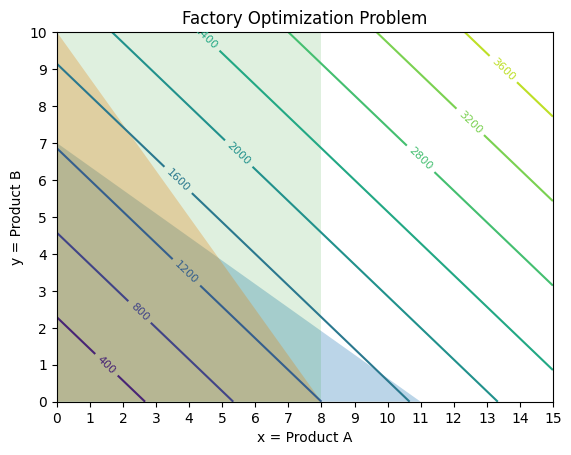

In [6]:
pa = 150
pb = 175

a = np.arange(0, 15.0 + 0.5, 0.5)  # 0:0.5:15
b = np.arange(0, 10.0 + 0.5, 0.5)  # 0:0.5:10

def f(a, b):
    return pa * a + pb * b

A, B = np.meshgrid(a, b)
Z = f(A, B)

plt.figure()

contours = plt.contour(A, B, Z, levels=10)
plt.clabel(contours, inline=True, fontsize=8)

# Titles and axis labels
plt.title("Factory Optimization Problem")
plt.xlabel("x = Product A")
plt.ylabel("y = Product B")

# Ticks
plt.xticks(np.arange(0, a.max() + 1, 1))
plt.yticks(np.arange(0, b.max() + 1, 1))

# --- Constraint regions (area plots) ---

# 1) 7a + 11b <= 77  ->  b <= (77 - 7a)/11, for a <= 11
a1 = a[a <= 11]
b1 = (77 - 7 * a1) / 11
b1 = np.maximum(b1, 0)  # avoid negative values
plt.fill_between(a1, 0, b1, alpha=0.3)

# 2) 10a + 8b <= 80  ->  b <= (80 - 10a)/8, for a <= 8
a2 = a[a <= 8]
b2 = (80 - 10 * a2) / 8
b2 = np.maximum(b2, 0)
plt.fill_between(a2, 0, b2, alpha=0.3)

# 3) a <= 8, 0 <= b <= max(b)  (vertical strip up to b_max)
a3 = a[a <= 8]
b_max = b.max()
plt.fill_between(a3, 0, b_max, alpha=0.15)

plt.xlim(0, a.max())
plt.ylim(0, b.max())

plt.show()

OKay. Let's create our Optimization model. 

### 1. Define the model and choose a solver

In python we use a model object to represent our optimization problem. We use **Gurobi** as the solver via its python interface 'gurobypy'.

The model is initially empty as we have not defined any variables, constraints, or objective. We create the model with gurobipy, which automatically selects Gurobi as our solver.

In [7]:
# create an empty model

model = gp.Model("Factory_Optimization")

print("Empty model created.")
print("Number of variables:", model.NumVars)
print("Number of constraints:", model.NumConstrs)


Restricted license - for non-production use only - expires 2027-11-29
Empty model created.
Number of variables: 0
Number of constraints: 0


### 2. Define Variables

Next, we define our variables by 'addVar'. Remember, x and y are our continuous non-negative decision variables, representing the number of production for products A and B. 

In [8]:

x = model.addVar(name="x", vtype=GRB.CONTINUOUS, lb=0, ub=8)  # Product A

y = model.addVar(name="y", vtype=GRB.CONTINUOUS, lb=0)  # Product B

model.update() # we update the model just to show the variables have been added. Later when you write your own code, you can skip this line.

print("Number of variables:", model.NumVars)
print("Number of constraints:", model.NumConstrs)

Number of variables: 2
Number of constraints: 0


Note that, we already satisfy the non-negativity and capacity constraints by setting the lb=0 and ub=8 for variable x and y. 


### 3. Define the objective 

Now, let's define the objective. In every optimization model, we also have some information given, in the form of paramters. We can define these parameters ourselves, or load them into our software from a CSV file if the size of the input data is large. The cost of the production for each product is a paramter which we define here.

In [9]:
pa = 150
pb = 175

model.setObjective(pa *x + pb *y, GRB.MAXIMIZE) # by GRB.MAXIMIZE we set the objective function to maximize profit

### 4. Define the constraints

Now the model knows the decision variables and objective, but it's time to bind the model with constraints. Remember, we already satisfied the non-nagtivity and capacity constraints when defining the variables. 

We need to define two different constraint in this simple example. The material constraint is:

$$ 7x+11y \le 11$$

In [10]:
material = model.addConstr(7 * x + 11 * y <= 77, name="Material_Constraint")

model.update() # we update the model just to show the variables have been added. Later when you write your own code, you can skip this line.

print("Number of variables:", model.NumVars)
print("Number of constraints:", model.NumConstrs)

Number of variables: 2
Number of constraints: 1


The next constraint is our time constraint which is:

$$ 10x + 8y \le 80 $$

In [11]:
time = model.addConstr(10 * x + 8 * y <= 80, name="Time_Constraint")

model.update() # we update the model just to show the variables have been added. Later when you write your own code, you can skip this line.

print("Number of variables:", model.NumVars)
print("Number of constraints:", model.NumConstrs)


Number of variables: 2
Number of constraints: 2


### 5. Solve the model

We have defined all of the chracteristics of our mathematical model in these lines of code. Now, it's time to solve the model and find the optimal x and y values.

In [12]:
model.optimize()

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2 rows, 2 columns and 4 nonzeros (Max)
Model fingerprint: 0x5b65b2f5
Model has 2 linear objective coefficients
Coefficient statistics:
  Matrix range     [7e+00, 1e+01]
  Objective range  [2e+02, 2e+02]
  Bounds range     [8e+00, 8e+00]
  RHS range        [8e+01, 8e+01]
Presolve time: 0.15s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7500000e+32   1.187500e+30   1.750000e+02      0s
       2    1.4138889e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.15 seconds (0.00 work units)
Optimal objective  1.413888889e+03


We can see that the optimal objective vaule is 1413.88, equal to the value that we have previously calculated in the lecture. 

### 6. Query the optimal solution

We can ask. the model to give us the optimal values for each decision variables.

In [13]:
print("Optimal number of Product A (x):", x.X)
print("Optimal number of Product B (y):", y.X)
print("Optimal profit:", model.ObjVal)

Optimal number of Product A (x): 4.888888888888888
Optimal number of Product B (y): 3.888888888888889
Optimal profit: 1413.8888888888887


Now let's define the MILP model for the Factory example.

In [14]:
pa = 150
pb = 175

milp = gp.Model("Factory_MILP_Optimization")

x = milp.addVar(name="x", vtype=GRB.INTEGER, lb=0, ub=8)  # Product A
y =milp.addVar(name="y", vtype=GRB.INTEGER, lb=0)  # Product B

milp.setObjective(pa *x + pb *y, GRB.MAXIMIZE) # by GRB.MAXIMIZE we set the objective function to maximize profit

milp.addConstr(7 * x + 11 * y <= 77, name="Material_Constraint")
milp.addConstr(10 * x + 8 * y <= 80, name="Time_Constraint")

milp.optimize()

print("Optimal number of Product A (x):", x.X)
print("Optimal number of Product B (y):", y.X)
print("Optimal profit:", milp.ObjVal)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2 rows, 2 columns and 4 nonzeros (Max)
Model fingerprint: 0x5b686d35
Model has 2 linear objective coefficients
Variable types: 0 continuous, 2 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e+00, 1e+01]
  Objective range  [2e+02, 2e+02]
  Bounds range     [8e+00, 8e+00]
  RHS range        [8e+01, 8e+01]
Found heuristic solution: objective 1200.0000000
Presolve time: 0.02s
Presolved: 2 rows, 2 columns, 4 nonzeros
Variable types: 0 continuous, 2 integer (0 binary)

Root relaxation: objective 1.396429e+03, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

The factory example was a very simple problem, which helped us understand the basics of optimization problems. Now, let's move on to a more complex problem.

## Example 2: Solar, wind and battery optimization




A small isolated energy company in Groningen supplies electricity to a local community. The community has a known electricity demand over a certain week. The company owns a wind and solar farm with a 150 and 50 Mega Watt (MW) capacity. 

It is also possible to buy electricity from the national grid, but it will cost the company. The electricity price is different during the week. The company has recently bought a large scale battery with the capacity of 80 Mega Watt hour to be able to charge/discharge energy when required. 

The goal is to minimize the total cost of electricity supply while ensuring all demand is met at every hour.

Assume no AC/DC conversion is required, and just consider the energy generated, stored, and supplied.

We seek to answer the following questions:
-   how should the company operate its PV-Wind-Battery system to maximize revenue?
-   What is the optimal time to charge/discharge?
-   Should the compaby buy electricity when the prices are low and store to use it later when there is energy deficit?

In order to maximize revenue, we need to minimize buying electricity from the grid. Furthermore, the generation from PV panels and wind turbines are dependent on weather data. Capacity factor (CF) of both generators is known at each hour, and specifies how much generation can happen on that hour. 

The required data is give in the 'Ex02.csv' files. Let's load the data and analyze it.

In [4]:
# First import the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gb
from gurobipy import GRB

In [6]:
df = pd.read_csv("Exercise_Files/Ex02.csv")

df.head(20)

,Time_Index,day,solar_cf,wind_cf,demand,electricity_price
0,1,1,0.00000,0.504,126,-0.02
1,2,1,0.00000,0.426,127,-0.05
2,3,1,0.00000,0.348,142,-0.02
3,4,1,0.00000,0.310,128,0.00
4,5,1,0.00000,0.338,128,0.04
5,6,1,0.00000,0.396,130,0.06
6,7,1,0.00962,0.518,133,0.54
7,8,1,0.04348,0.522,135,2.24
8,9,1,0.18603,0.588,135,2.00
9,10,1,0.38459,0.782,134,1.35


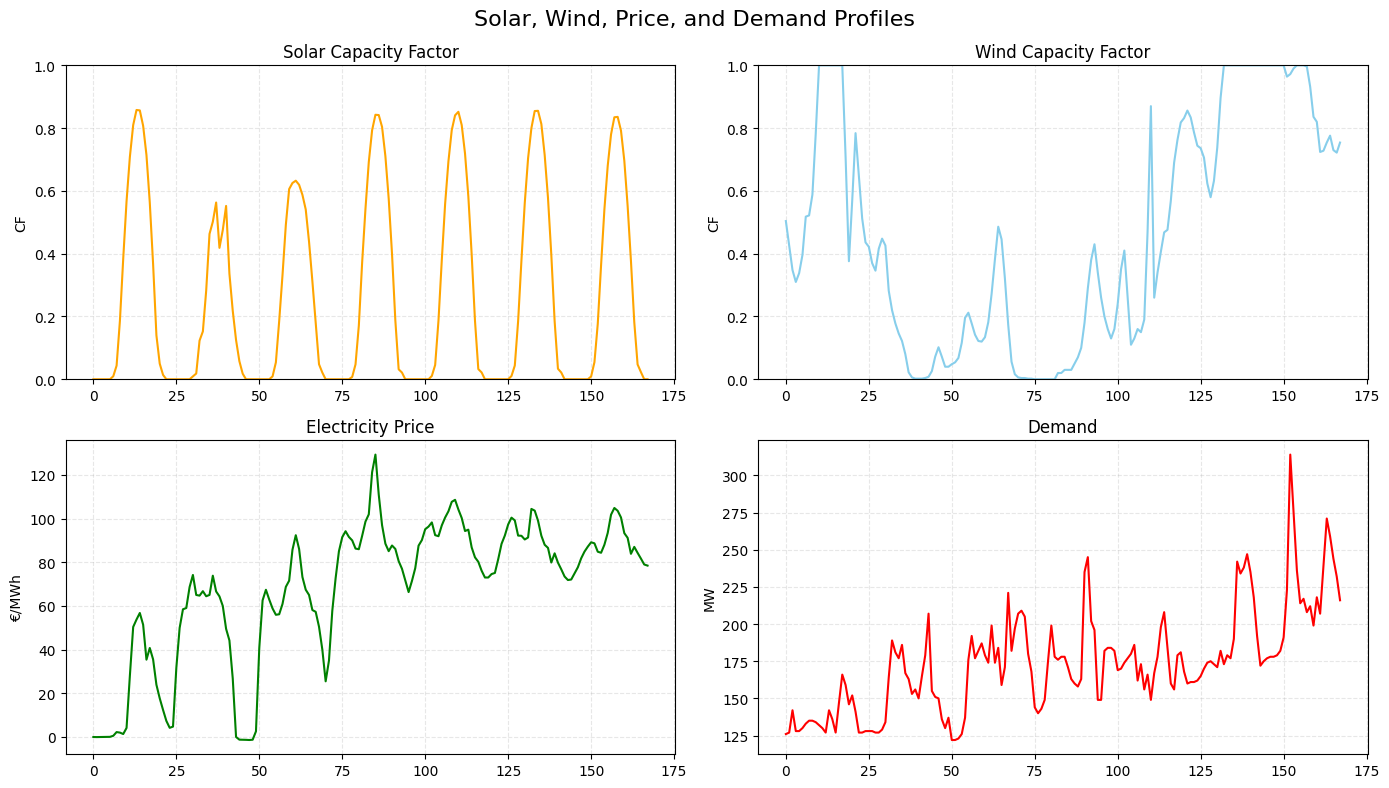

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle("Solar, Wind, Price, and Demand Profiles", fontsize=16)

# --- 1. Solar capacity factor ---
axs[0, 0].plot(df['solar_cf'], color='orange')
axs[0, 0].set_title("Solar Capacity Factor")
axs[0, 0].set_ylabel("CF")
axs[0, 0].set_ylim(0, 1)
axs[0, 0].grid(True, linestyle="--", alpha=0.3)

# --- 2. Wind capacity factor ---
axs[0, 1].plot(df['wind_cf'], color='skyblue')
axs[0, 1].set_title("Wind Capacity Factor")
axs[0, 1].set_ylabel("CF")
axs[0, 1].set_ylim(0, 1)
axs[0, 1].grid(True, linestyle="--", alpha=0.3)

# --- 3. Electricity price ---
axs[1, 0].plot(df['electricity_price'], color='green')
axs[1, 0].set_title("Electricity Price")
axs[1, 0].set_ylabel("€/MWh")
axs[1, 0].grid(True, linestyle="--", alpha=0.3)

# --- 4. Demand ---
axs[1, 1].plot(df['demand'], color='red')
axs[1, 1].set_title("Demand")
axs[1, 1].set_ylabel("MW")
axs[1, 1].grid(True, linestyle="--", alpha=0.3)

# Improve spacing
plt.tight_layout()
plt.show()

Let T represent set of all time steps in during the week. We show the power generation from PV and wind at each hour as

- Let $T$ show set of all hours of the week
- We show power generation from PV and Wind at each hour as: $ x^{wind}_t , x^{pv}_t $
- Battery charge/discharge is denoted as: $ x^{cha}_t , x^{dis}_t $
- Electricoty import is: $ x^{imp}_t$
- State of Charge (SOC) of the battery chages at each hour as charge and discharge happens\
- We assume electricity import is always available
- Assume efficiency of the battery for charge and discharge is 100% and no energy is lost, and the battery is empty in the beginnning of the week.

We can formulate our optimization problem like following:

$$
\begin{align}
\min \quad & \sum_{t \in T} Cost^{ele}_t  x^{imp}_t \\
\text{s.t. } \\
& x^{wind}_t + x^{pv}_t + x^{dis}_t - x^{cha}_t + x^{imp}_t = Demand_t\\
&  x^{wind}_t \le Capacity^{wind} * CF^{wind}_t\\
&  x^{pv}_t \le Capacity^{pv} * CF^{pv}_t\\
&  SOC_t = SOC_{t-1} + x^{cha}_t - x^{dis}_t \\
\end{align}
$$

Now, Let's begin with creating our model to optimize operation of the system. First, load the given data as parameter.

### 1. Define the parameters

In [8]:
solar_capacity = 50  # MW - Capacity of the PV panels
wind_capacity = 150   # MW - Capacity of the Wind turbines
battery_capacity = 80  # MWh - Capacity of the Battery system

SOC_start = 0  # MWh - Initial State of Charge of the Battery system

T = df['Time_Index'].tolist()  # [1, 2, ..., 168]
T_full = [0] + T
price = df.set_index('Time_Index')['electricity_price'].to_dict()


### 2. Create the model

In [9]:
energy_model = gb.Model("Energy_System_Optimization")

Restricted license - for non-production use only - expires 2027-11-29


### 3. Decision variables

Now we have to define our decision variables. For each of our time intervals, we have five important operating decisions to make:

- How much to generate from PV panels?
- How much to generate from wind turbines?
- How much electricity should we buy from the grid?
- How much energy to charge into the battery?
- How much discharge should we have from the battery to meet the demand?

We also have define a final variable:

- How much energy should be stored in the battery? ($SOC_t$)

While this state of charge variable is technically defined as a decision variable, it is actually completely constrained by the other variables, as we'll see below. This is an example of a state variable.

Additionally, we define lower bounds for each decision variable to satisfy the non-negativity constraints, as generation, discharge, charge, and import should not be negative. SOC will also be bounded by zero and capacity of the battery.

In [10]:
Gen_PV = energy_model.addVars(T, name="PV_gen", lb=0, vtype=GRB.CONTINUOUS)
Gen_Wind = energy_model.addVars(T, name="Wind_gen", lb=0, vtype=GRB.CONTINUOUS)
Import = energy_model.addVars(T, name="Electricity_Import", lb=0, vtype=GRB.CONTINUOUS)
Charge = energy_model.addVars(T, name="Battery_Charge", lb=0, ub=battery_capacity, vtype=GRB.CONTINUOUS)
Discharge = energy_model.addVars(T, name="Battery_Discharge", lb=0, ub=battery_capacity, vtype=GRB.CONTINUOUS)
SOC = energy_model.addVars(T_full, name="Battery_SOC", lb=0, ub=battery_capacity, vtype=GRB.CONTINUOUS)


energy_model.update()

print("Number of variables added:", energy_model.NumVars)


Number of variables added: 1009


### 4. Objective of the model

In [11]:
energy_model.setObjective(
    gb.quicksum(Import[t] * price[t] for t in T),
    GRB.MINIMIZE
)

### 5. Defining the Constraints


In [12]:
#1. We have to make sure that we conserve enrgy in each time interval. 
# Power generated from generators over each hour plus the discharged energy from battery plus the imported electricity should be equal to the demand plus the charged energy into the battery. 
# This is called energy balance constraint.
energy_model.addConstrs((Gen_PV[t] + Gen_Wind[t] + Discharge[t] + Import[t] == df.loc[df['Time_Index'] == t, 'demand'].values[0] + Charge[t] for t in T), name="Energy_Balance")

# 2. Next, we impose the battery level constraint, which also forces the balance of energy in the batteries. 
# The battery level at the current time step, should be equal to the SOC at previous time step plus the energy stored in the battery, minus the discharged energy.
energy_model.addConstr(SOC[0] == SOC_start, name="Initial_SOC")
energy_model.addConstrs((SOC[t]== SOC[t-1]+ Charge[t]- Discharge[t] for t in T), name=f"Battery_Energy_Balance")

# 3. The next set of constraints is enforced to make sure the generators do not generate more energy than their capacity and availability at time t.
energy_model.addConstrs(Gen_PV[t] <= solar_capacity * df.loc[df['Time_Index'] == t, 'solar_cf'].values[0] for t in T)
energy_model.addConstrs(Gen_Wind[t] <= wind_capacity * df.loc[df['Time_Index'] == t, 'wind_cf'].values[0] for t in T)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

In [13]:
energy_model.optimize()


if energy_model.status != GRB.OPTIMAL:
    print("No optimal solution found.")
else:
    results = pd.DataFrame(index= T)
    results.index.name = 'Time'

    results['PV_Generation'] = [Gen_PV[t].X for t in T]
    results['Wind_Generation'] = [Gen_Wind[t].X for t in T]
    results['Electricity_Import'] = [Import[t].X for t in T]
    results['Battery_Charge'] = [Charge[t].X for t in T]
    results['Battery_Discharge'] = [Discharge[t].X for t in T]
    results['Battery_SOC'] = [SOC[t].X for t in T]

    if 0 in SOC.keys():
        results["SOC"] = [SOC[t].X for t in T]
    else:
        # If SOC only defined for T
        results["SOC"] = [SOC[t].X for t in T]

    display(results.head())

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 673 rows, 1009 columns and 1849 nonzeros (Min)
Model fingerprint: 0xe3b89308
Model has 166 linear objective coefficients
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 1e+02]
  Bounds range     [8e+01, 8e+01]
  RHS range        [3e-01, 3e+02]
Presolve removed 614 rows and 837 columns
Presolve time: 0.04s
Presolved: 59 rows, 172 columns, 225 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.6256156e+05   5.732344e+02   0.000000e+00      0s
      62    1.0310207e+06   0.000000e+00   0.000000e+00      0s

Solved in 62 iterations and 0.06 seconds (0.00 work units)
Optimal objective  1.031020652e+06


,PV_Generation,Wind_Generation,Electricity_Import,Battery_Charge,Battery_Discharge,Battery_SOC,SOC
Time,,,,,,,
1,0.0,0.0,126.0,0.0,0.0,0.0,0.0
2,0.0,0.0,207.0,80.0,0.0,80.0,80.0
3,0.0,0.0,142.0,0.0,0.0,80.0,80.0
4,0.0,0.0,128.0,0.0,0.0,80.0,80.0
5,0.0,50.7,77.3,80.0,80.0,80.0,80.0


We can see that the model has grown noticebly in size, compared to our factory problem. However, it still solves the problem quite fast, since the problem is linear.

Let's see what is our optimal operating plan in the system. 

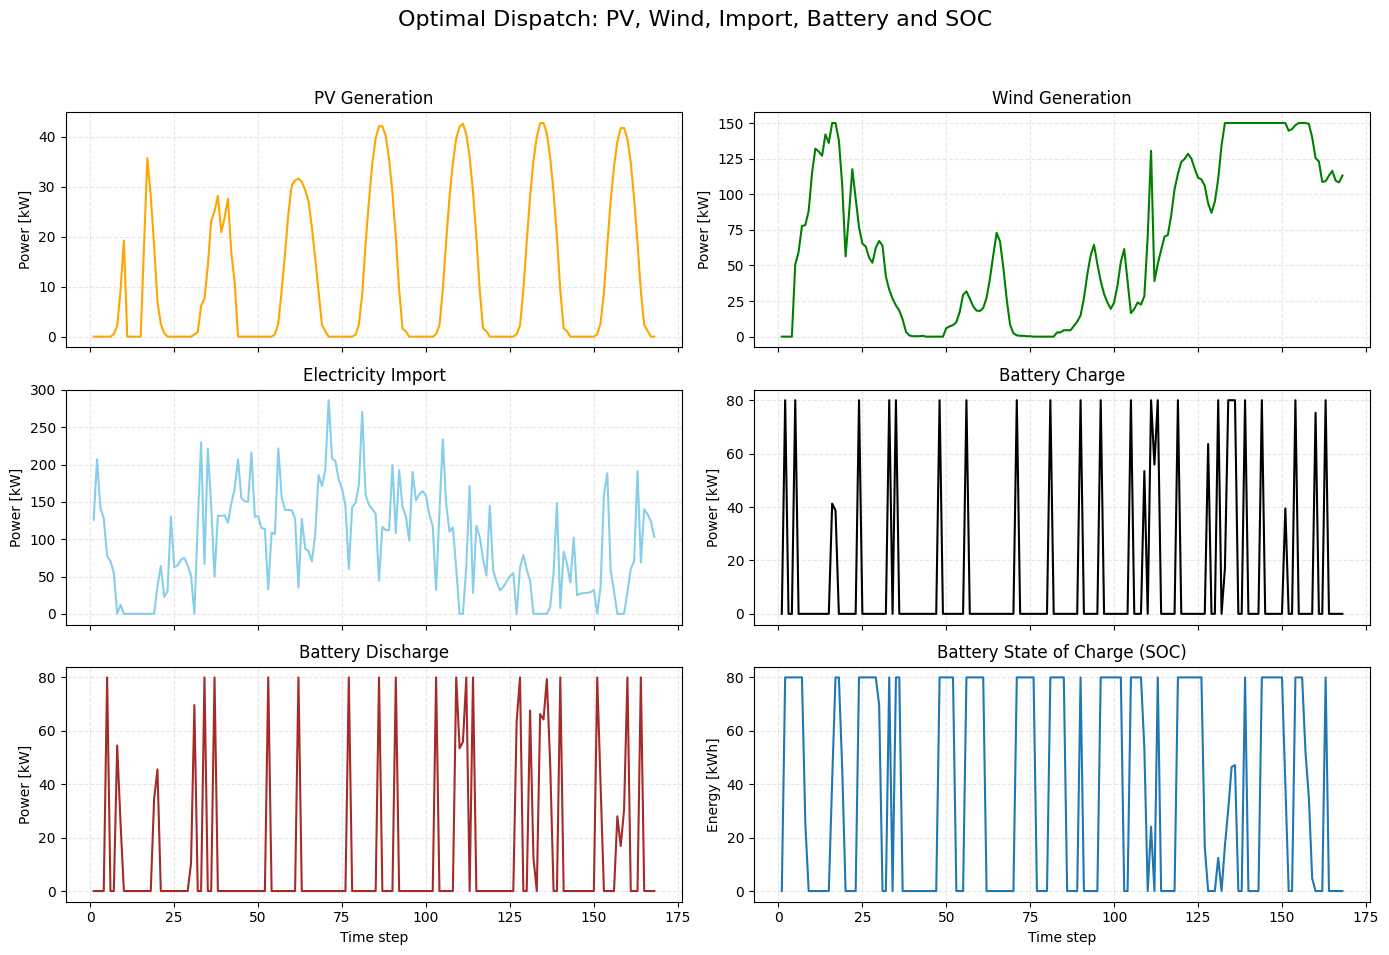

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(14, 10), sharex=True)
fig.suptitle("Optimal Dispatch: PV, Wind, Import, Battery and SOC", fontsize=16)

time = results.index

# 1) PV generation
axs[0, 0].plot(time, results["PV_Generation"], color='orange')
axs[0, 0].set_title("PV Generation")
axs[0, 0].set_ylabel("Power [kW]")
axs[0, 0].grid(True, linestyle="--", alpha=0.3)

# 2) Wind generation
axs[0, 1].plot(time, results["Wind_Generation"], color='green')
axs[0, 1].set_title("Wind Generation")
axs[0, 1].set_ylabel("Power [kW]")
axs[0, 1].grid(True, linestyle="--", alpha=0.3)

# 3) Electricity import
axs[1, 0].plot(time, results["Electricity_Import"], color='skyblue')
axs[1, 0].set_title("Electricity Import")
axs[1, 0].set_ylabel("Power [kW]")
axs[1, 0].grid(True, linestyle="--", alpha=0.3)

# 4) Battery charge
axs[1, 1].plot(time, results["Battery_Charge"], color='black')
axs[1, 1].set_title("Battery Charge")
axs[1, 1].set_ylabel("Power [kW]")
axs[1, 1].grid(True, linestyle="--", alpha=0.3)

# 5) Battery discharge
axs[2, 0].plot(time, results["Battery_Discharge"], color='brown')
axs[2, 0].set_title("Battery Discharge")
axs[2, 0].set_ylabel("Power [kW]")
axs[2, 0].set_xlabel("Time step")
axs[2, 0].grid(True, linestyle="--", alpha=0.3)

# 6) State of charge
axs[2, 1].plot(time, results["Battery_SOC"])
axs[2, 1].set_title("Battery State of Charge (SOC)")
axs[2, 1].set_ylabel("Energy [kWh]")
axs[2, 1].set_xlabel("Time step")
axs[2, 1].grid(True, linestyle="--", alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for main title
plt.show()